# Pretrained CNN + Encoder-Decoder

## Setup

In [206]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from __future__ import print_function, division

import os
import sys

# NOTE: Inferring the project root path like this will not always work
# (e.g. when the notebook resides on a different server to the kernel)
# Set the path directly if necessary.
root_path = os.path.dirname(os.getcwd())

sys.path.append(root_path)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import time
import copy
import glob
import re
import importlib
from PIL import Image

from imednet.data.smnist_loader import MatLoader, Mapping
from imednet.trainers.encoder_decoder_trainer import Trainer

plt.ion()   # interactive mode

## Load Model

Helper function for loading saved models:

In [207]:
def load_model(root_path, model_path):
    # Read network description file
    with open(os.path.join(root_path, model_path, 'network_description.txt')) as f:
        network_description_str = f.read()

    # Get the model class from the network description and dynamically import it
    model_module_class_str = re.search('Model: (.+?)\n', network_description_str).group(1)
    model_module_str = os.path.splitext(model_module_class_str)[0]
    model_class_str = os.path.splitext(model_module_class_str)[1][1:]
    model_module = importlib.import_module(model_module_str)
    model_class = getattr(model_module, model_class_str)

    # Get the pre-trained CNN model load path from the network description
    if model_class_str == 'CNNEncoderDecoderNet':
        pre_trained_cnn_model_path = os.path.join(root_path, re.search('Pre-trained CNN model load path: (.+?)\n', network_description_str).group(1))

    # Load layer sizes
    layer_sizes = np.load(os.path.join(model_path, 'layer_sizes.npy')).tolist()

    # Load scaling
    scaling = Mapping()
    scaling.x_max = np.load(os.path.join(root_path, model_path, 'scale_x_max.npy'))
    scaling.x_min = np.load(os.path.join(root_path, model_path, 'scale_x_min.npy'))
    scaling.y_max = np.load(os.path.join(root_path, model_path, 'scale_y_max.npy'))
    scaling.y_min = np.load(os.path.join(root_path, model_path, 'scale_y_min.npy'))

    # Load the model
    if model_class_str == 'CNNEncoderDecoderNet':
        model = model_class(pre_trained_cnn_model_path, layer_sizes, scaling)
    else:
        model = model_class(layer_sizes, None, scaling)
        
    # Load the model state parameters
    state = torch.load(os.path.join(root_path, model_path, 'net_parameters'))
    model.load_state_dict(state)
    
    return model

Select and load one of the below models:

### Image-to-Motion Encoder Decoder (IMEDNet)

In [183]:
model_path = os.path.join(root_path, 'models/encoder_decoder/40x40-smnist 2018-07-19 14:03:57.743758/')
model = load_model(root_path, model_path)
model_stub = 'imednet_etoe'

### Image-to-Motion Encoder Decoder (IMEDNet) Trained with Adam

In [208]:
model_path = os.path.join(root_path, 'models/encoder_decoder/40x40-smnist-adam 2018-07-22 18:44:42.318301/')
model = load_model(root_path, model_path)
model_stub = 'imednet_etoe_adam'

### Convolutional Image-to-Motion Encoder-Decoder (CIMEDNet) with Frozen Convolutional Layer Weights

In [9]:
model_path = os.path.join(root_path, 'models/cnn_encoder_decoder/40x40-smnist 2018-07-18 14:04:44.658272/')
model = load_model(root_path, model_path)
model_stub = 'cimednet_frozenconv'

### Convolutional Image-to-Motion Encoder-Decoder (CIMEDNet) Trained End-to-End

In [463]:
model_path = os.path.join(root_path, 'models/cnn_encoder_decoder/40x40-smnist-end-to-end 2018-07-19 15:21:32.827139')
model = load_model(root_path, model_path)
model_stub = 'cimednet_etoe'

### Convolutional Image-to-Motion Encoder-Decoder with Fully-Connected Encoder Layers (CFCIMEDNet) Trained End-to-End

In [465]:
model_path = os.path.join(root_path, 'models/cnn_encoder_decoder/40x40-smnist 2018-07-18 15:20:38.156659/')
model = load_model(root_path, model_path)
model_stub = 'cfcimednet_etoe'

### Convolutional Image-to-Motion Encoder-Decoder (CIMEDNet) with Frozen Convolutional Layer Weights, Trained with Adam

In [ ]:
model_path = os.path.join(root_path, 'models/cnn_encoder_decoder/cimednet-40x40-smnist-adam 2018-07-22 17:10:44.630909')
model = load_model(root_path, model_path)
model_stub = 'cimednet_frozenconv_adam'

### Convolutional Image-to-Motion Encoder-Decoder (CIMEDNet) Trained End-to-End with Adam

In [ ]:
model_path = os.path.join(root_path, 'models/cnn_encoder_decoder/cimednet-40x40-smnist-end-to-end-adam 2018-07-22 17:10:57.504620')
model = load_model(root_path, model_path)
model_stub = 'cimednet_etoe_adam'

### Convolutional Image-to-Motion Encoder-Decoder with Fully-Connected Encoder Layers (CFCIMEDNet) with Frozen Convolutional Layer Weights, Trained with Adam

In [ ]:
model_path = os.path.join(root_path, 'models/cnn_encoder_decoder/cfcimednet-40x40-smnist-adam 2018-07-22 17:11:11.006303/')
model = load_model(root_path, model_path)
model_stub = 'cfcimednet_frozenconv_adam'

### Convolutional Image-to-Motion Encoder-Decoder with Fully-Connected Encoder Layers (CFCIMEDNet) Trained End-to-End with Adam

In [53]:
model_path = os.path.join(root_path, 'models/cnn_encoder_decoder/cfcimednet-40x40-smnist-end-to-end-adam 2018-07-22 17:11:17.144898/')
model = load_model(root_path, model_path)
model_stub = 'cfcimednet_etoe_adam'

## Load Data

Select and load one of the below datasets.

### Synthetic MNIST (s-MNIST)

In [146]:
data_path = os.path.join(root_path, 'data/s-mnist/40x40-smnist-seed-42.mat')
data_stub = 'smnist'

### Synthetic MNIST with Additive White Gaussian Noise with 19.0 Signal-to-Noise Ratio (s-MNIST-AWGN-19-SNR)

In [209]:
data_path = os.path.join(root_path, 'data/s-mnist/40x40-smnist-with-awgn-double-snr-seed-42.mat')
data_stub = 'smnist_awgn_19_0_snr'

### Synthetic MNIST with Additive White Gaussian Noise with 9.5 Signal-to-Noise Ratio (s-MNIST-AWGN-9.5-SNR)

In [64]:
data_path = os.path.join(root_path, 'data/s-mnist/40x40-smnist-with-awgn-seed-42.mat')
data_stub = 'smnist_awgn_9_5_snr'

### Synthetic MNIST with Motion Blur (s-MNIST-MB)

In [69]:
data_path = os.path.join(root_path, 'data/s-mnist/40x40-smnist-with-motion-blur-seed-42.mat')
data_stub = 'smnist_mb'

### Synthetic MNIST with Reduced Contrast and Additive White Gaussian Noise (s-MNIST-RC-AWGN)

In [74]:
data_path = os.path.join(root_path, 'data/s-mnist/40x40-smnist-with-reduced-contrast-and-awgn-seed-42.mat')
data_stub = 'smnist_rc_awgn'

### Synthetic MNIST with Gaussian Background

In [79]:
data_path = os.path.join(root_path, 'data/s-mnist/40x40-smnist-with-gaussian-background.mat')
data_stub = 'gaussian_background'

In [84]:
data_path = os.path.join(root_path, 'data/s-mnist/40x40-smnist-inverted-with-gaussian-background.mat')
data_stub = 'inverted_with_gaussian_background'

## Test Model on Data

In [210]:
# Load data and scale it
images, outputs, scale, original_trj = MatLoader.load_data(data_path)

# Load the data split from the 'net_indeks.npy' file.
# NOTE: This is the train/val/test split that was used to divide the
# dataset originally used to train the model.
# We use the same split on the other datasets listed here for
# convenience, because they are the same size.
# TODO: This should be fixed.  The data splitting function should
# be moved from the trainer to the data loaders.
trainer = Trainer()
# trainer.indeks = np.load(os.path.join(model_path, 'net_indeks.npy'))
    
# input_data_train_b, output_data_train_b, \
#     input_data_test_b, output_data_test_b, \
#     input_data_validate_b, output_data_validate_b \
#     = trainer.split_dataset(images, outputs)

In [211]:
# torch_images = input_data_test_b[test_sample_indices, :]
# torch_outputs = output_data_test_b[test_sample_indices, :]

In [214]:
# test_sample_indices = [410, 1121, 22, 2953, 2174, 175, 26, 97, 98, 149]
indices = np.asarray(range(0,len(images)))
test_sample_indices = indices[1:-1:10]

/home0/barry.ridge/anaconda3/envs/py3.6_tf1.8.0_cuda9.2/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


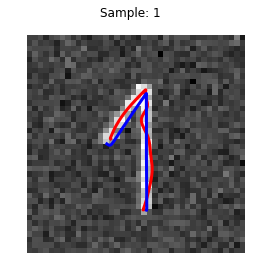

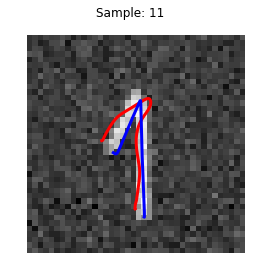

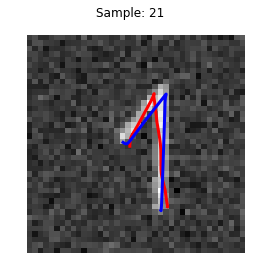

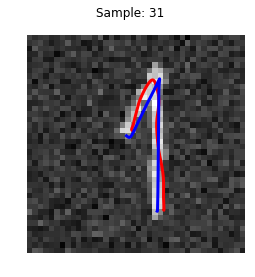

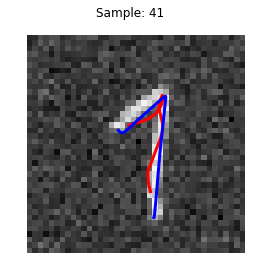

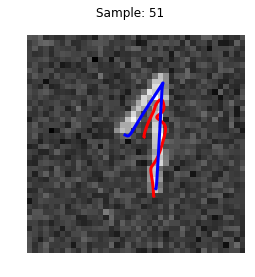

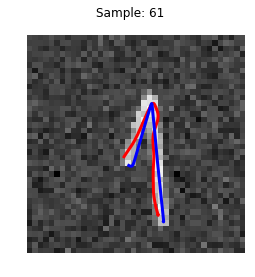

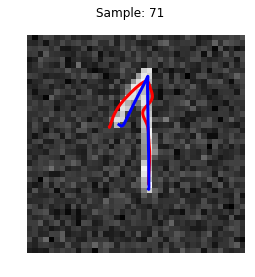

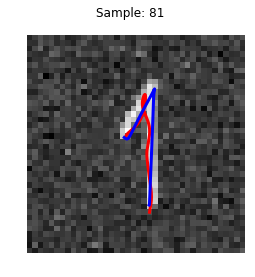

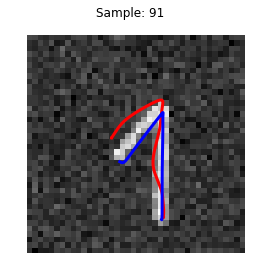

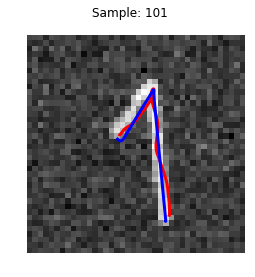

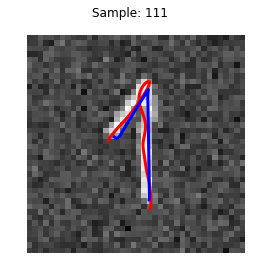

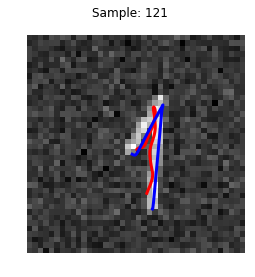

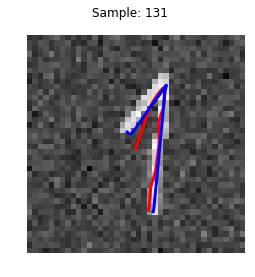

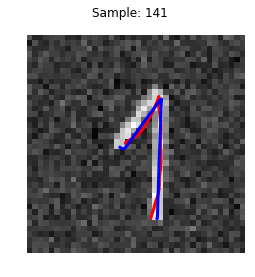

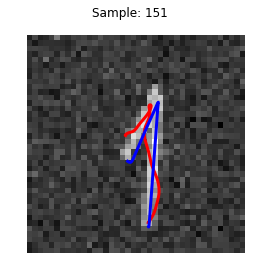

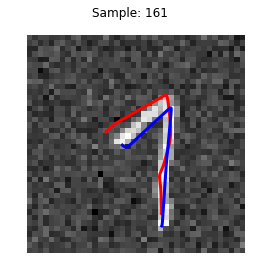

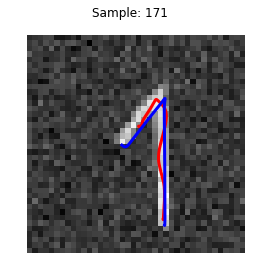

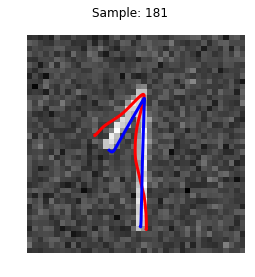

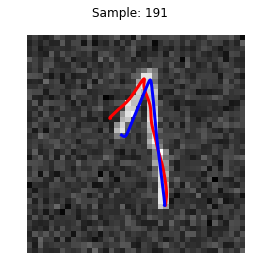

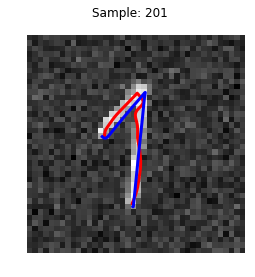

In [ ]:
torch_images = torch.autograd.Variable(torch.from_numpy(images[test_sample_indices, :])).float()
torch_outputs = torch.autograd.Variable(torch.from_numpy(outputs[test_sample_indices, :])).float()

torch_predicted_outputs = model(torch_images)

for i_sample in range(torch_predicted_outputs.shape[0]):
    sample_output_dmp = trainer.create_dmp(torch_outputs[i_sample,:], model.scale, 0.01, 25, True)
    torch_sample_predicted_output = torch.cat((torch.tensor([-1.]), torch_predicted_outputs[i_sample,:]), 0)
    sample_predicted_output_dmp = trainer.create_dmp(torch_sample_predicted_output, model.scale, 0.01, 25, True)
    sample_output_dmp.joint()
    fig = trainer.show_dmp(torch_images[i_sample,:], sample_output_dmp.Y, sample_predicted_output_dmp, plot=False)
    fig.suptitle('Sample: {}'.format(test_sample_indices[i_sample], fontsize=20))
    # fig.savefig(os.path.join(root_path, 'figures/', model_stub + '_' + data_stub + '_' + str(i_sample) + '.png'))
    # mat = trainer.show_dmp(torch_images[i_sample,:], None, sample_predicted_output_dmp, plot=False)

## Transfer to Unseen MNIST Digit Images

In [89]:
import mnist
from mnist import MNIST
mndata = MNIST(os.path.join(root_path, 'data/mnist'))
mnist_images, mnist_labels = mndata.load_training()
mnist_images = np.asarray(mnist_images)
mnist_images.shape

(60000, 784)

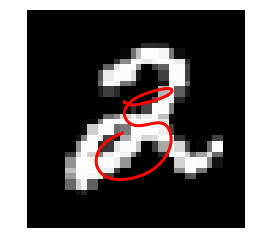

In [145]:
i_sample = np.random.randint(mnist_images.shape[0])
mnist_sample = mnist_images[i_sample,:].reshape(28,28)
pil_mnist_sample = Image.fromarray(np.uint8(mnist_sample))
pil_scaled_mnist_sample = pil_mnist_sample.resize((40,40))
scaled_mnist_sample = np.array(pil_scaled_mnist_sample).reshape(1,40*40)
scaled_mnist_sample = scaled_mnist_sample / np.max(scaled_mnist_sample)
torch_scaled_mnist_sample = torch.autograd.Variable(torch.from_numpy(scaled_mnist_sample)).float()
torch_scaled_mnist_sample_predicted_output = model(torch_scaled_mnist_sample)
torch_scaled_mnist_sample_predicted_output = torch.cat((torch.tensor([-1.]), torch_scaled_mnist_sample_predicted_output[0,:]), 0)
scaled_mnist_sample_predicted_output_dmp = trainer.create_dmp(torch_scaled_mnist_sample_predicted_output, model.scale, 0.01, 25, True)
scaled_mnist_sample_predicted_output_dmp.joint()
mat = trainer.show_dmp(scaled_mnist_sample, None, scaled_mnist_sample_predicted_output_dmp, plot=False)